In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [4]:
print("{} rows and {} features in train set".format(df_train.shape[0], df_train.shape[1]))
print("{} rows and {} features in test set".format(df_test.shape[0], df_test.shape[1]))

27100 rows and 18 features in train set
18050 rows and 17 features in test set


In [5]:
print(df_train.isnull().sum())


id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [6]:
print(df_test.isnull().sum())

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64


<Axes: xlabel='month', ylabel='count'>

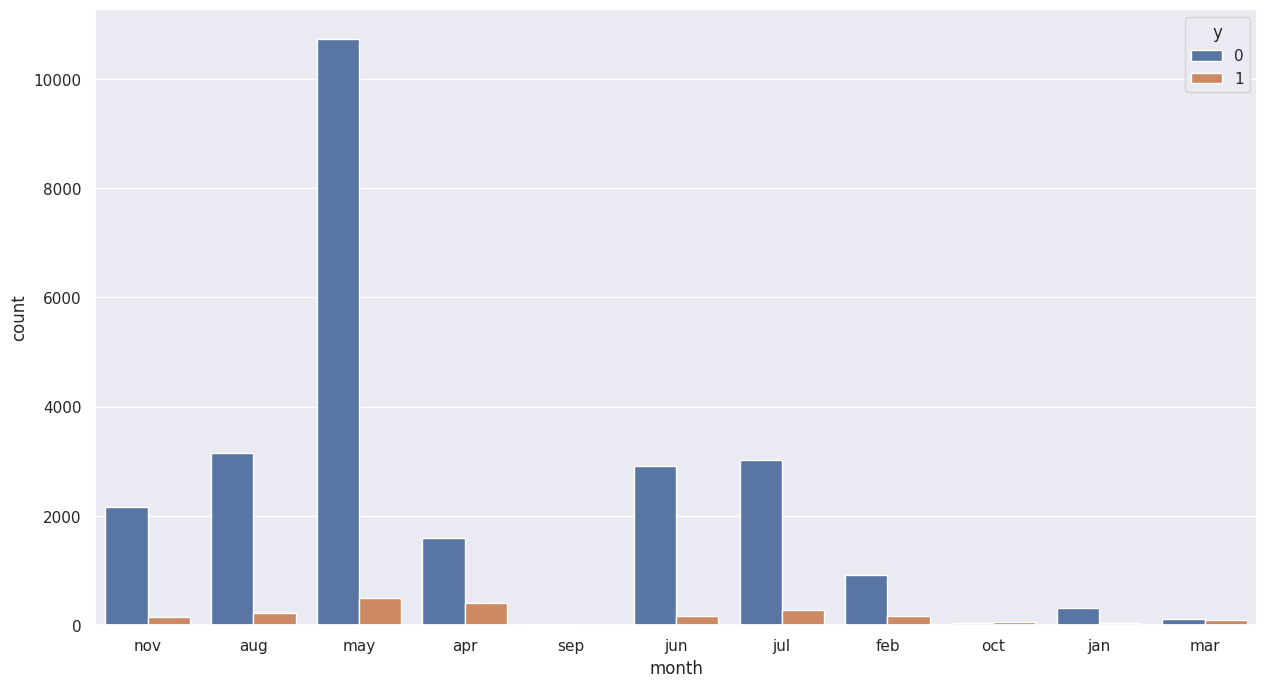

In [7]:
target_col = "y"

sns.set(rc={"figure.figsize": (15, 8)})
sns.countplot(x="month", hue=target_col, data=df_train)

In [52]:
data = pd.concat([df_train, df_test], sort=False)

# no yes を 0 と 1 に変更
data['default'].replace(['no', 'yes'], [0, 1], inplace=True)
data['housing'].replace(['no', 'yes'], [0, 1], inplace=True)
data['loan'].replace(['no', 'yes'], [0, 1], inplace=True)

# クラス分類したいんだけど、まだ扱う術を知らないのでとりあえずバイバイ

data['marital'] = data['marital'].map({'married':0, 'single':1, 'divorced':2}).astype(int)
data['contact'] = data['contact'].map({'cellular':1,  'unknown':0, 'telephone':2}).astype(int)
data['month'] = data['month'].map({'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec':12}).astype(int)
data['education'] = data['education'].map({'primary':1, 'secondary':2, 'tertiary':3, 'unknown':0})

# jobは多すぎるのでsklearnに頼る（知ってたら他も使うんだけどな）
from sklearn.preprocessing import LabelEncoder
job_le = LabelEncoder()
data['job'] = job_le.fit_transform(data['job'])

# pdaysは-1とそれ以外で分ける
data.loc[data['pdays']>=0, 'pdays'] = 1 
data.loc[~data['pdays']>=0, 'pdays'] = 0

# previousは0とそれ以外で分ける
data.loc[data['previous']!=0, 'previous'] = 1

# 使わない奴を落とす

delete_columns = ['balance', 'contact', 'month', 'age', 'day', 'campaign', 'poutcome']

data.drop(delete_columns, axis=1, inplace=True)


In [53]:
from sklearn.model_selection import train_test_split

In [54]:
train = data[:len(df_train)]
test = data[len(df_train):]

y_train = train['y'].astype(int)
X_train = train.drop('y', axis=1)
X_test = test.drop('y', axis=1)

print(X_train.head())

   id  job  marital  education  default  housing  loan  duration  pdays  \
0   0    7        0          2        0        1     0       101      1   
1   1    2        1          3        0        0     0       158      1   
2   2    4        0          3        0        1     0       351      1   
3   3    9        0          2        0        1     1       658      1   
4   4   10        0          1        0        1     0       177      1   

   previous  
0         0  
1         0  
2         0  
3         0  
4         0  


In [55]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

In [56]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'pdays', 'previous']

In [61]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)

lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

params = {
    'objective': 'binary'
}

# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4#training-api%E3%81%AE%E5%A0%B4%E5%90%88-2
# lightGBMの書き方がちょっと違うらしい

model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], num_boost_round=1000, callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True), lgb.log_evaluation(0)])

y_pred = model.predict(X_test, num_interaction=model.best_iteration)

[LightGBM] [Info] Number of positive: 1478, number of negative: 17492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 383
[LightGBM] [Info] Number of data points in the train set: 18970, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.077912 -> initscore=-2.471054
[LightGBM] [Info] Start training from score -2.471054
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.21142	valid_1's binary_logloss: 0.237789
[LightGBM] [Warning] Unknown parameter: num_interaction


In [62]:
y_pred = (y_pred > 0.5).astype(int)

In [64]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
import lightgbm as lgb
import numpy as np

In [65]:
FOLD = 5
NUM_ROUND = 1000

params = {
    'objective': 'binary'
}

valid_scores = []
models = []

kf = KFold(n_splits=FOLD, shuffle=True, random_state=0)

for fold, (train_indices, valid_indices) in enumerate(kf.split(X_train)):
    print(fold, train_indices, valid_indices)
    X_t, X_v = X_train[train_indices], X_train[valid_indices]
    y_t, y_v = y_train[train_indices], y_train[valid_indices]

    lgb_train = lgb.Dataset(X_t, y_t, categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_v, y_v, categorical_feature=categorical_features)
    
    model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], num_boost_round=1000, callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True), lgb.log_evaluation(0)])

    y_valid_pred = model.predict(X_v)

    score = mean_absolute_error(y_v, y_valid_pred)

    print(f'fold {fold}, MAE: {score}')
    valid_scores.append(score)
    models.append(model)

cv_score = np.mean(valid_scores)
print('CV score: {cv_score}')

KeyError: "None of [Index([    0,     1,     2,     3,     4,     5,     6,     7,     9,    10,\n       ...\n       18957, 18958, 18959, 18961, 18962, 18964, 18965, 18967, 18968, 18969],\n      dtype='int64', length=15176)] are in the [columns]"